# TEJ 風格多因子選股模型範例

此 Notebook 示範：
1. 資料載入（若無實際檔案，會自動產生 Demo 資料）
2. 計算 Value / Quality / Momentum / Risk 因子
3. 截面標準化因子並組合為多因子分數
4. 計算因子 IC / IR
5. 以簡單等權多頭組合進行回測並輸出績效與淨值曲線


In [12]:
pip install pandas numpy pathlib dataclasses typing matplotlib scipy

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   - -------------------------------------- 1.8/38.6 MB 14.4 MB/s eta 0:00:03
   ------ --------------------------------- 6.0/38.6 MB 17.6 MB/s eta 0:00:02
   ---------- ----------------------------- 10.0/38.6 MB 17.7 MB/s eta 0:00:02
   -------------- ------------------------- 14.2/38.6 MB 18.2 MB/s eta 0:00:02
   ------------------ --------------------- 17.8/38.6 MB 17.8 MB/s eta 0:00:02
   ---------------------- ----------------- 21.2/38.6 MB 17.9 MB/s eta 0:00:01
   ------------------------- -------------- 24.9/38.6 MB 17.9 MB/s eta 0:00:01
   ----------------------------- ---------- 28.6/38.6 MB 17.8 MB/s eta 0:00:01
   --------------------------------- ------ 32.5/38.6 MB 17.9 MB/s eta 0:00:01
   ------------------------------------- -- 36.4/38.6 MB 18.0 MB/s eta 0:00:01
   ---------------------------------------- 38.6/38.6 MB 17.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated package

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

np.random.seed(42)
DATA_DIR = Path("./data")
REBAlANCE_FREQ = "M"  # 每月調整
TOP_QUANTILE = 0.2     # 前 20% 股票
COST_BPS = 10          # 換手成本 10 bps (=0.1%)

def load_price_fundamental_data(filepath: Path) -> pd.DataFrame:
    """載入價量 + 財務因子資料。
    若檔案不存在，會自動產生 Demo 資料方便測試整體流程。
    期望欄位至少包含：date, stock_id, close, pe, pb, roe, gross_margin。
    """
    if not filepath.exists():
        print(f"[WARN] 找不到 {filepath}，自動產生 Demo 資料用於測試。")
        dates = pd.date_range("2020-01-01", "2021-12-31", freq="B")
        stock_ids = [f"STK{i:03d}" for i in range(1, 21)]
        data = []
        for sid in stock_ids:
            price = 50 + np.cumsum(np.random.randn(len(dates)))
            pe = 10 + np.random.rand(len(dates)) * 10
            pb = 1 + np.random.rand(len(dates)) * 4
            roe = 0.05 + np.random.rand(len(dates)) * 0.15
            gm = 0.2 + np.random.rand(len(dates)) * 0.3
            vol = np.random.randint(100_000, 1_000_000, size=len(dates))
            for d, p, _pe, _pb, _roe, _gm, _vol in zip(dates, price, pe, pb, roe, gm, vol):
                data.append(
                    {
                        "date": d,
                        "stock_id": sid,
                        "open": p * (1 + np.random.randn() * 0.005),
                        "high": p * (1 + abs(np.random.randn()) * 0.01),
                        "low": p * (1 - abs(np.random.randn()) * 0.01),
                        "close": p,
                        "volume": _vol,
                        "pe": _pe,
                        "pb": _pb,
                        "roe": _roe,
                        "gross_margin": _gm,
                    }
                )
        df = pd.DataFrame(data)
    else:
        df = pd.read_csv(filepath)

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["stock_id", "date"]).reset_index(drop=True)
    return df

def compute_value_factors(df: pd.DataFrame) -> pd.DataFrame:
    """Value 因子：1/PE、1/PB 等，愈大代表愈便宜。"""
    df = df.copy()
    df["pe_pos"] = df["pe"].replace({0: np.nan})
    df["value_pe_inv"] = 1.0 / df["pe_pos"]
    df["pb_pos"] = df["pb"].replace({0: np.nan})
    df["value_pb_inv"] = 1.0 / df["pb_pos"]
    return df

def compute_quality_factors(df: pd.DataFrame) -> pd.DataFrame:
    """Quality 因子：ROE、毛利率等。"""
    df = df.copy()
    df["quality_roe"] = df["roe"]
    df["quality_gross_margin"] = df["gross_margin"]
    return df

def compute_momentum_factors(
    df: pd.DataFrame,
    lookback_months: int = 12,
    skip_last_month: bool = True,
) -> pd.DataFrame:
    """Momentum 因子：12M-1M 價格動能。"""
    df = df.copy()
    df = df.sort_values(["stock_id", "date"])
    df["ret_daily"] = df.groupby("stock_id")["close"].pct_change()

    lb_days = lookback_months * 21
    skip_days = 21 if skip_last_month else 0
    df["log_ret"] = np.log1p(df["ret_daily"])
    df["log_ret_shifted"] = df.groupby("stock_id")["log_ret"].shift(skip_days)

    rolling = (
        df.groupby("stock_id")["log_ret_shifted"]
        .rolling(window=lb_days, min_periods=int(lb_days * 0.8))
        .sum()
        .reset_index(level=0, drop=True)
    )
    df["mom_12m_1m"] = np.expm1(rolling)
    return df

def compute_risk_factors(df: pd.DataFrame, lookback_days: int = 60) -> pd.DataFrame:
    """Risk 因子：近 N 日波動度。"""
    df = df.copy()
    df = df.sort_values(["stock_id", "date"])
    if "ret_daily" not in df.columns:
        df["ret_daily"] = df.groupby("stock_id")["close"].pct_change()
    df["risk_volatility"] = (
        df.groupby("stock_id")["ret_daily"]
        .rolling(window=lookback_days, min_periods=int(lookback_days * 0.8))
        .std()
        .reset_index(level=0, drop=True)
    )
    return df

def winsorize_series(s: pd.Series, lower_q: float = 0.01, upper_q: float = 0.99) -> pd.Series:
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lower=lo, upper=hi)

def zscore_series(s: pd.Series) -> pd.Series:
    mean = s.mean()
    std = s.std()
    if std == 0 or np.isnan(std):
        return pd.Series(0.0, index=s.index)
    return (s - mean) / std

def cross_sectional_standardize(df: pd.DataFrame, factor_cols: List[str]) -> pd.DataFrame:
    df = df.copy()
    def _cs_norm(group: pd.DataFrame) -> pd.DataFrame:
        for col in factor_cols:
            group[col] = winsorize_series(group[col])
            group[col] = zscore_series(group[col])
        return group
    df = df.groupby("date", group_keys=False).apply(_cs_norm)
    return df

def combine_factors(
    df: pd.DataFrame,
    factor_cols: List[str],
    method: str = "equal_weight",
    ic_weights: Dict[str, float] = None,
) -> pd.DataFrame:
    df = df.copy()
    if method == "equal_weight":
        df["score_multi_factor"] = df[factor_cols].mean(axis=1)
    elif method == "ic_weight":
        if ic_weights is None:
            raise ValueError("使用 ic_weight 必須提供 ic_weights")
        weights = np.array([ic_weights.get(col, 0.0) for col in factor_cols])
        if np.all(weights == 0):
            raise ValueError("ic_weights 全為 0，請檢查輸入")
        weights = weights / np.abs(weights).sum()
        df["score_multi_factor"] = (df[factor_cols] * weights).sum(axis=1)
    else:
        raise ValueError(f"Unknown method: {method}")
    return df

def prepare_next_period_return(df: pd.DataFrame, holding_period: int = 21) -> pd.DataFrame:
    df = df.copy()
    df = df.sort_values(["stock_id", "date"])
    df["future_ret"] = (
        df.groupby("stock_id")["close"]
        .pct_change(periods=holding_period)
        .shift(-holding_period)
    )
    return df

def compute_ic_ir(df: pd.DataFrame, factor_cols: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ic_records = []
    for dt, g in df.groupby("date"):
        g = g.dropna(subset=["future_ret"])
        if len(g) < 10:
            continue
        for fac in factor_cols:
            if g[fac].isna().all():
                continue
            ic_value = g[fac].corr(g["future_ret"], method="spearman")
            ic_records.append((dt, fac, ic_value))
    if not ic_records:
        return pd.DataFrame(), pd.DataFrame()
    ic_df = pd.DataFrame(ic_records, columns=["date", "factor", "ic"])
    ic_pivot = ic_df.pivot(index="date", columns="factor", values="ic").sort_index()
    summary = []
    for fac in factor_cols:
        if fac not in ic_pivot.columns:
            continue
        series = ic_pivot[fac].dropna()
        if len(series) == 0:
            continue
        ic_mean = series.mean()
        ic_std = series.std()
        ir = ic_mean / (ic_std + 1e-9)
        summary.append({"factor": fac, "ic_mean": ic_mean, "ic_std": ic_std, "ir": ir})
    summary_df = pd.DataFrame(summary).set_index("factor").sort_values("ic_mean", ascending=False)
    return ic_pivot, summary_df

@dataclass
class BacktestResult:
    daily_returns: pd.Series
    equity_curve: pd.Series
    turnover: pd.Series
    stats: Dict[str, float]

def generate_rebalance_dates(df: pd.DataFrame, freq: str = "M") -> list[pd.Timestamp]:
    """
    產生調整日：
    - 先把 date 轉成 datetime
    - 每個 period（例如每個月）取該 period 內「最後一個交易日」當作 rebalancing day
    """
    df_dates = pd.DataFrame({"date": pd.to_datetime(df["date"])})
    # 建立 period 欄位，例如 2019-01、2019-02 ...
    df_dates["period"] = df_dates["date"].dt.to_period(freq)
    # 每個 period 取最大日期
    rebal = df_dates.groupby("period")["date"].max().sort_values()
    # 回傳 list[pd.Timestamp]
    return list(rebal.values)



def compute_performance_stats(ret: pd.Series, trading_days: int = 252) -> Dict[str, float]:
    ret = ret.dropna()
    if len(ret) == 0:
        return {}
    total_ret = (1 + ret).prod() - 1
    years = len(ret) / trading_days
    if years > 0:
        cagr = (1 + total_ret) ** (1 / years) - 1
    else:
        cagr = np.nan
    vol = ret.std() * np.sqrt(trading_days)
    sharpe = ret.mean() / (ret.std() + 1e-9) * np.sqrt(trading_days)
    cum = (1 + ret).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    max_dd = dd.min()
    return {
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "MaxDrawdown": max_dd,
        "TotalReturn": total_ret,
    }

def backtest_long_only_equal_weight(
    df: pd.DataFrame,
    score_col: str,
    top_quantile: float = 0.2,
    freq: str = "M",
    cost_bps: float = 10,
) -> BacktestResult:
    df = df.copy()
    df = df.sort_values(["date", "stock_id"])
    if "ret_daily" not in df.columns:
        df["ret_daily"] = df.groupby("stock_id")["close"].pct_change()
    all_dates = df["date"].drop_duplicates().sort_values()
    last_date = all_dates.iloc[-1]
    rebal_dates = generate_rebalance_dates(df, freq=freq)
    stocks = df["stock_id"].drop_duplicates().tolist()
    weights = pd.DataFrame(0.0, index=all_dates, columns=stocks)
    prev_weights = pd.Series(0.0, index=stocks)
    for i, dt in enumerate(rebal_dates):
        cross = df[df["date"] == dt].copy()
        cross = cross.dropna(subset=[score_col])
        if len(cross) == 0:
            continue
        cross = cross.sort_values(score_col, ascending=False)
        n_pick = max(1, int(len(cross) * top_quantile))
        selected = cross["stock_id"].iloc[:n_pick].tolist()
        new_weights = pd.Series(0.0, index=stocks)
        new_weights[selected] = 1.0 / len(selected)
        if i < len(rebal_dates) - 1:
            next_dt = rebal_dates[i + 1]
        else:
            next_dt = last_date
        holding_period_dates = all_dates[(all_dates >= dt) & (all_dates <= next_dt)]
        for d in holding_period_dates:
            weights.loc[d, :] = new_weights
        prev_weights = new_weights
    ret_panel = (
        df.pivot(index="date", columns="stock_id", values="ret_daily")
        .reindex(index=all_dates, columns=stocks)
    )
    portfolio_ret_before_cost = (weights * ret_panel).sum(axis=1)
    turnover = weights.diff().abs().sum(axis=1) / 2.0
    cost = turnover * (cost_bps / 10000.0)
    portfolio_ret_after_cost = portfolio_ret_before_cost - cost
    portfolio_ret_after_cost = portfolio_ret_after_cost.fillna(0.0)
    equity_curve = (1 + portfolio_ret_after_cost).cumprod()
    stats = compute_performance_stats(portfolio_ret_after_cost)
    return BacktestResult(
        daily_returns=portfolio_ret_after_cost,
        equity_curve=equity_curve,
        turnover=turnover,
        stats=stats,
    )

print("環境與函數定義完成。")


環境與函數定義完成。


,date,stock_id,open,high,low,close,volume,pe,pb,roe,gross_margin
0,2019-01-02,2317,53.145727,53.145727,52.029220,52.178085,16775306,NaN,NaN,NaN,NaN
1,2019-01-03,2317,51.359318,51.657054,50.987149,51.284885,36198461,NaN,NaN,NaN,NaN
2,2019-01-04,2317,50.763847,50.763847,49.870644,50.317245,37013571,NaN,NaN,NaN,NaN
3,2019-01-07,2317,51.136011,51.657051,50.838281,51.582619,24084557,NaN,NaN,NaN,NaN
4,2019-01-08,2317,51.805915,51.805915,50.763841,51.061577,18303188,NaN,NaN,NaN,NaN


C:\Users\johns\AppData\Local\Temp\ipykernel_17220\3562529235.py:128: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("date", group_keys=False).apply(_cs_norm)


因子 IC / IR 統計：


""


回測績效指標：
CAGR: 0.3894
Volatility: 0.3654
Sharpe: 1.0825
MaxDrawdown: -0.4541
TotalReturn: 5.6773


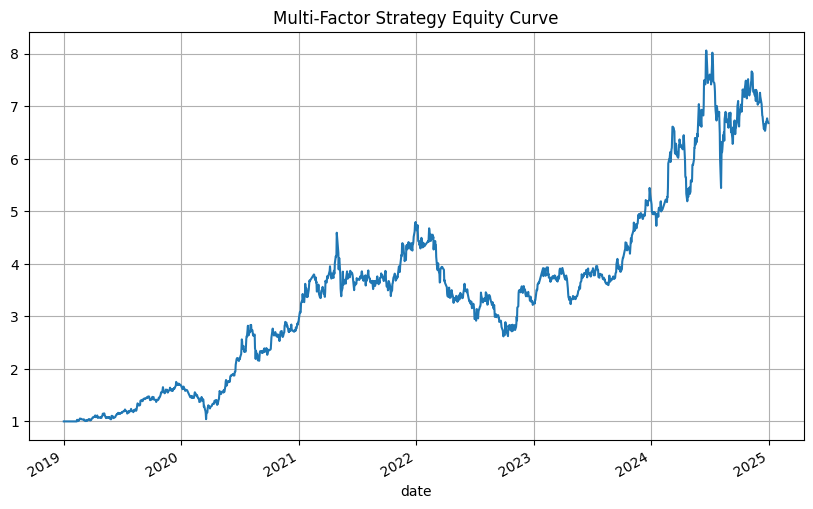

In [8]:
# 主流程：執行資料載入、因子計算、IC/IR 與回測

raw_df = load_price_fundamental_data(DATA_DIR / "prices_fundamentals_taiwan.csv")
display(raw_df.head())

df = compute_value_factors(raw_df)
df = compute_quality_factors(df)
df = compute_momentum_factors(df, lookback_months=12, skip_last_month=True)
df = compute_risk_factors(df, lookback_days=60)
df = prepare_next_period_return(df, holding_period=21)

factor_cols = [
    "value_pe_inv",
    "value_pb_inv",
    "quality_roe",
    "quality_gross_margin",
    "mom_12m_1m",
    "risk_volatility",
]

df = cross_sectional_standardize(df, factor_cols=factor_cols)
ic_df, ic_summary = compute_ic_ir(df, factor_cols=factor_cols)
print("因子 IC / IR 統計：")
display(ic_summary)

df = combine_factors(df, factor_cols=factor_cols, method="equal_weight")
bt_res = backtest_long_only_equal_weight(
    df=df,
    score_col="score_multi_factor",
    top_quantile=TOP_QUANTILE,
    freq=REBAlANCE_FREQ,
    cost_bps=COST_BPS,
)

print("回測績效指標：")
for k, v in bt_res.stats.items():
    print(f"{k}: {v:.4f}")

plt.figure(figsize=(10, 6))
bt_res.equity_curve.plot()
plt.title("Multi-Factor Strategy Equity Curve")
plt.grid(True)
plt.show()
